In [477]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [478]:
filepath = '/content/drive/MyDrive/Progetto Colab/'

# Importazione dataset e controllo valori nulli

In [479]:
import pandas as pd
df = pd.read_excel(filepath+'data/Electronic.xlsx')
df

,Tipo,Score,Text
0,Electronic,Negative,"Fakespot gave you a C rating ""Our engine has p..."
1,Electronic,Negative,Worked for awhile then they broke.
2,Electronic,Negative,Does not work for bigger drives
3,Electronic,Positive,Easy installation. All controls at your finge...
4,Electronic,Negative,LIKE SCROLL.
...,...,...,...
22255,Electronic,Negative,I have purchased two of these AmazonBasics HDM...
22256,Electronic,Negative,Great while it worked! But it just stops char...
22257,Electronic,Positive,Perfect for the areas i'm using them.
22258,Electronic,Positive,Worked great; I don't think there is much else...


In [480]:
df.isna().sum()

Tipo     0
Score    0
Text     1
dtype: int64

In [481]:
df.Score.value_counts()

Positive    12051
Negative    10209
Name: Score, dtype: int64

### Rimozione NaN e split X e y

In [482]:
df_not_na = df[~(df['Text'].isna())]
raw_text = df_not_na['Text']
#assegno i valori alla mia y
y = df_not_na['Score'].tolist()
raw_text[5]

'I purchased several products which claimed to allow PS2 devices to work with USB adapter. None worked. When I viewed comments on this product the majority of comments praised this product and stated it worked fine. The comments impressed me, so I purchased the device. Tried it on a PS2 mouse and just like all thje others, it did not work. Will just purchase USB devices in the furture.'

### Lowercase, Remove punctuation, Tokenize, Lemmatization

In [483]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [484]:
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

text = raw_text.str.lower().str.replace('[^\w\s\d]',' ', regex=True) # \d tiene anche i caratteri numerici
text = text.str.split()
text = text.apply(lambda x: [lemmatizer.lemmatize(sent) for sent in x])
for row in text:
    [row.remove(i) for i in row if len(i) < 2]
print(text[0])
train_sentences = []
for row in text:
    train_sentences.append(' '.join([item for item in row ]))
train_sentences[1]

['fakespot', 'gave', 'you', 'c', 'rating', 'our', 'engine', 'ha', 'profiled']


'worked for awhile then they broke'

### BoW

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#n_gram da 1 a 1, quindi mono gram, imposto 2000 features, quindi si ferma alle 2000 parole piu frequenti
vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=2000)
X = vectorizer.fit_transform(train_sentences)

#salva in un dizionario i nomi delle features, associando a un codice
feature_names = vectorizer.get_feature_names()
X = X.toarray()
X = np.array(X)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Modello di classificazione

### Creazione train/test

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

### Grid Search Naive bayes

In [ ]:
#Questa griglia ci permette di determinare i migliori parametri di tuning
#Il Naive bayes non è scelto per il progetto
# Best Accuracy : 0.853, 'alpha': 1.0 Cibo
# Best Accuracy : 0.754, 'alpha': 0.5 Finance
# Best Accuracy : 0.861, 'alpha': 10.0 Disneyland
# Best Accuracy : 0.855, 'alpha': 10.0 Electronic

'''
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
params = {'alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 10.0, ],}

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(x_train,y_train)

print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)
'''

"\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.naive_bayes import MultinomialNB\nparams = {'alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 10.0, ],}\n\nmultinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)\nmultinomial_nb_grid.fit(x_train,y_train)\n\nprint('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)\nprint('Best Parameters : ',multinomial_nb_grid.best_params_)\n"

### Grid Search Random Forest

In [ ]:
#Utilizzare solo in caso di necessità (tempi molto lunghi)
#Questa griglia ci permette di determinare i migliori parametri di tuning
#Best: 0.821146 using {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300} Cibo
#Best: 0.787776 using {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200} Finance
#Best: 0.821431 using {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300} Disneyland
#Best: 0.869970 using {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300} Electronic
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#cross_validated_grid_search for Random Forest

model = RandomForestClassifier()
param_grid = {'n_estimators': [200, 300],#numero di alberi
               'criterion': ['gini', 'entropy'],#purezza misurata con gini e entropia
               'max_depth': [None, 5, 10], #profondità massima dell'albero
               'min_samples_split': [2, 10, 20]} #Il numero minimo di campioni necessari per dividere un nodo interno

grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=3, verbose=2, n_jobs=-1)#default è accuracy
# Fit the random search model
%time grid_result = grid.fit(x_train, y_train)

#print grid search results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

'\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn import svm\n\n#cross_validated_grid_search for Random Forest\n\nmodel = RandomForestClassifier()\nparam_grid = {\'n_estimators\': [200, 300],#numero di alberi\n               \'criterion\': [\'gini\', \'entropy\'],#purezza misurata con gini e entropia\n               \'max_depth\': [None, 5, 10], #profondità massima dell\'albero\n               \'min_samples_split\': [2, 10, 20]} #Il numero minimo di campioni necessari per dividere un nodo interno\n\ngrid = GridSearchCV(estimator = model, param_grid = param_grid, cv=3, verbose=2, n_jobs=-1)#default è accuracy\n# Fit the random search model\n%time grid_result = grid.fit(x_train, y_train)\n\n#print grid search results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_res

### Modello migliore per modello surrogato

In [ ]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

#Modello RF
#model = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_split= 2, n_estimators= 300) #cibo e Disneyland
model = RandomForestClassifier(criterion= 'entropy', max_depth= None, min_samples_split= 10, n_estimators= 300) #Electronic
#model = RandomForestClassifier(criterion= 'entropy', max_depth= None, min_samples_split= 10, n_estimators= 200) #Finance

model.fit(X,y)
predicted = model.predict(X)

In [ ]:
import pandas as pd
import numpy as np

RF = pd.DataFrame(list(zip(X,predicted)), columns = ['testo','score'])

### Modello surrogato per assegnazione pesi

In [ ]:
X = RF['testo'].tolist()
y = RF['score'].tolist()

X = np.array(X)
y = np.array(y)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight=None)

model.fit(X, y)

pred = model.predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Comprensione pesi e assegnazione punteggio

(array([  2.,   9.,  44., 162., 603., 786., 297.,  75.,  18.,   4.]),
 array([-3.79688358, -3.06700607, -2.33712856, -1.60725105, -0.87737354,
        -0.14749603,  0.58238148,  1.31225899,  2.0421365 ,  2.77201401,
         3.50189152]),
 <a list of 10 Patch objects>)

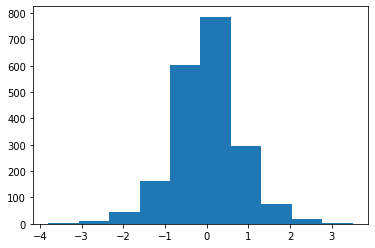

In [ ]:
coef=model.coef_#valori coefficiente
#feature_names sono le parole associate ai coefficiente

#Distribuzione coefficiente
import matplotlib
import matplotlib.pyplot as pp
pp.hist(coef[0])

### Tecnica 1

In [ ]:
'''
df1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})
df1.sort_values(by=["Coeff"], ascending = False, inplace = True)
for i in range(len(df1)):
  if df1.Coeff[i]>2: #coefficiente maggiore di 2, punteggio 4
    df1.Punteggio[i]=4
  elif df1.Coeff[i]>1.5: #coefficiente maggiore di 1.5, punteggio 3.5
    df1.Punteggio[i]=3.5
  elif df1.Coeff[i]>1: #coefficiente maggiore di 1, punteggio 3
    df1.Punteggio[i]=3
  elif df1.Coeff[i]>.5: #coefficiente maggiore di 0.5, punteggio 2.5
    df1.Punteggio[i]=2.5
  elif df1.Coeff[i]<-.5: #coefficiente minore di -0.5, punteggio -2.5
    df1.Punteggio[i]=-2.5
  elif df1.Coeff[i]<-1: #coefficiente minore di -1, punteggio -3
    df1.Punteggio[i]=-3
  elif df1.Coeff[i]<-1.5: #coefficiente minore di -1.5, punteggio -3.5
    df1.Punteggio[i]=-3.5
  elif df1.Coeff[i]<-2: #coefficiente minore di -2, punteggio -4
    df1.Punteggio[i]=-4
  else:
    df1.drop(i, inplace=True) 
'''

'\ndf1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})\ndf1.sort_values(by=["Coeff"], ascending = False, inplace = True)\nfor i in range(len(df1)):\n  if df1.Coeff[i]>2: #coefficiente maggiore di 2, punteggio 4\n    df1.Punteggio[i]=4\n  elif df1.Coeff[i]>1.5: #coefficiente maggiore di 1.5, punteggio 3.5\n    df1.Punteggio[i]=3.5\n  elif df1.Coeff[i]>1: #coefficiente maggiore di 1, punteggio 3\n    df1.Punteggio[i]=3\n  elif df1.Coeff[i]>.5: #coefficiente maggiore di 0.5, punteggio 2.5\n    df1.Punteggio[i]=2.5\n  elif df1.Coeff[i]<-.5: #coefficiente minore di -0.5, punteggio -2.5\n    df1.Punteggio[i]=-2.5\n  elif df1.Coeff[i]<-1: #coefficiente minore di -1, punteggio -3\n    df1.Punteggio[i]=-3\n  elif df1.Coeff[i]<-1.5: #coefficiente minore di -1.5, punteggio -3.5\n    df1.Punteggio[i]=-3.5\n  elif df1.Coeff[i]<-2: #coefficiente minore di -2, punteggio -4\n    df1.Punteggio[i]=-4\n  else:\n    df1.drop(i, inplace=True) \n'

### Tecnica 2 (vincente)

In [ ]:
df1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})
df1.sort_values(by=["Coeff"], ascending = False, inplace = True)
for i in range(len(df1)):
  if df1.Coeff[i]>0.6: #coefficiente maggiore di 0.6, punteggio 4
    df1.Punteggio[i]=4
  elif df1.Coeff[i]<-0.6: #coefficiente minore di -0.6, punteggio -4
    df1.Punteggio[i]=-4
  else:
    df1.drop(i, inplace=True) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Tecnica 3

In [ ]:
'''
df1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})
df1.sort_values(by=["Coeff"], ascending = False, inplace = True)
for i in range(len(df1)):
  if df1.Coeff[i]>1: #coefficiente maggiore di 1, punteggio 4
    df1.Punteggio[i]=4
  elif df1.Coeff[i]>.5: #coefficiente maggiore di 0.5, punteggio 3
    df1.Punteggio[i]=3
  elif df1.Coeff[i]<-.5: #coefficiente minore di -0.5, punteggio -3
    df1.Punteggio[i]=-3
  elif df1.Coeff[i]<-1: #coefficiente minore di -1, punteggio -4
    df1.Punteggio[i]=-4
  else:
    df1.drop(i, inplace=True) 
'''

'\ndf1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})\ndf1.sort_values(by=["Coeff"], ascending = False, inplace = True)\nfor i in range(len(df1)):\n  if df1.Coeff[i]>1: #coefficiente maggiore di 1, punteggio 4\n    df1.Punteggio[i]=4\n  elif df1.Coeff[i]>.5: #coefficiente maggiore di 0.5, punteggio 3\n    df1.Punteggio[i]=3\n  elif df1.Coeff[i]<-.5: #coefficiente minore di -0.5, punteggio -3\n    df1.Punteggio[i]=-3\n  elif df1.Coeff[i]<-1: #coefficiente minore di -1, punteggio -4\n    df1.Punteggio[i]=-4\n  else:\n    df1.drop(i, inplace=True) \n'

##Creazione dizionario

In [ ]:
#Dizionario per migliorare vader
#La chiave sarà la parola e il valore sarà il punteggio assegnato
new_words =  dict([([a,b]) for a,b in zip(df1['Parola'], df1['Punteggio'])])
print(new_words)

{'excellent': 4, 'perfect': 4, 'handy': 4, 'awesome': 4, 'wonderful': 4, 'solid': 4, 'job': 4, 'thank': 4, 'love': 4, 'great': 4, 'perfectly': 4, 'slim': 4, 'notice': 4, 'nice': 4, 'exactly': 4, 'convenient': 4, 'complaint': 4, 'vacuum': 4, 'profile': 4, 'described': 4, 'satisfied': 4, 'thanks': 4, 'cb': 4, 'mistake': 4, 'protect': 4, 'easy': 4, 'beat': 4, 'tiffen': 4, 'amazing': 4, 'effect': 4, 'pleased': 4, 'hosa': 4, 'saved': 4, 'detail': 4, 'happy': 4, 'kos': 4, 'easier': 4, 'flawlessly': 4, 'correct': 4, 'durable': 4, 'film': 4, '4k': 4, 'incredible': 4, 'fast': 4, 'trick': 4, 'audiophile': 4, 'crisp': 4, 'needed': 4, 'streaming': 4, 'superb': 4, 'paste': 4, 'charm': 4, 'helpful': 4, 'fantastic': 4, 'best': 4, 'accurate': 4, 'fancy': 4, 'surprised': 4, 'expected': 4, 'klipsch': 4, 'game': 4, 'fortunately': 4, 'owned': 4, 'plenty': 4, 'solved': 4, 'advertised': 4, 'dog': 4, 'good': 4, 'reasonable': 4, 'recorded': 4, 'sturdy': 4, 'treadmill': 4, 'dragon': 4, 'lense': 4, 'improved': 

##Salvataggio Dizionario

In [ ]:
import json
tf = open(filepath+"dizionario/Dizionario_electronic.json", "w")
json.dump(new_words,tf)
tf.close()

#FINE

###Tutto quello che viene dopo verrà eliminato

In [ ]:
df = pd.read_excel(filepath+'data/Electronic_learning.xlsx')

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

#Vader
analyzer = SentimentIntensityAnalyzer()

df['scores'] = df['Text'].apply(lambda review: analyzer.polarity_scores(review))
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

#Vader mio
SIA = SentimentIntensityAnalyzer()
SIA.lexicon.update(new_words)
df['scores2'] = df['Text'].apply(lambda review: SIA.polarity_scores(review))
df['compound2']  = df['scores2'].apply(lambda score_dict: score_dict['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
Fine = pd.DataFrame({'Score': df.Score,'Text': df.Text,'Vader': df.compound,'Vader_new': df.compound2})
Fine['Vader'] = df['compound'].apply(lambda x: 'Positive' if x > 0 else 'Negative' )
Fine['Vader_new'] = df['compound2'].apply(lambda x: 'Positive' if x > 0 else 'Negative' )

In [ ]:
v=0
vn=0
for i in range(len(Fine)):
  if Fine.Score[i]==Fine.Vader[i]:
    v+=1
  if Fine.Score[i]==Fine.Vader_new[i]:
    vn+=1

print("Percentuale tra i due vader")
print("Vader",round((v/len(Fine)*100),2),"%")
print("Vader Nuovo",round(((vn/len(Fine))*100),2),"%")

Percentuale tra i due vader
Vader 75.54 %
Vader Nuovo 83.21 %


#Salvataggio testo vader con nuove parole

In [ ]:
f = open(filepath+"vader_new/vader_lexicon_electronic.txt", "w")
for k, v in SIA.lexicon.items():
    f.write(str(k) + '\t'+ str(v) + '\n')
f.close()